In [8]:
import os
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

from langchain_openai import AzureChatOpenAI

from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

from langchain_anthropic import ChatAnthropic

from langsmith import traceable

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [9]:
llm = AzureChatOpenAI(
    api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    api_version=os.getenv("API_VERSION"),
    azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
    model=os.getenv("MODEL_NAME"),
    )

In [10]:
@traceable
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [11]:
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

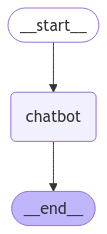

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [14]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  Hi


Assistant: Hello! How can I assist you today?


User:  What is langGraph?


Assistant: LangGraph is a framework designed to facilitate the development of language models and natural language processing applications. It aims to provide tools and infrastructure that support the creation, training, and deployment of sophisticated language understanding systems. LangGraph typically emphasizes modularity, scalability, and ease of integration with other technologies, making it a versatile choice for developers working on language-related projects. Depending on the context, it might also refer to specific libraries or components within a broader ecosystem focused on language modeling and processing.


User:  Can we setup langsmith in Azure?


Assistant: Yes, you can set up LangSmith in Azure. LangSmith, a platform for managing and deploying language models, can be hosted on cloud platforms like Azure. Here’s a general guide on how you might go about setting it up:

1. **Azure Account and Subscription**: Ensure you have an active Azure account and subscription.

2. **Resource Group**: Create a resource group in Azure to manage all related resources for LangSmith.

3. **Virtual Machine (VM)**:
   - Deploy a virtual machine to host LangSmith. Choose the appropriate size and specs based on your expected computational needs.
   - Ensure the VM has the necessary OS and dependencies required by LangSmith.

4. **Networking**:
   - Set up virtual networks and subnets as needed.
   - Configure network security groups to manage inbound and outbound traffic.
   - Consider setting up a Load Balancer if you deploy multiple instances for scalability.

5. **Storage**:
   - Use Azure Blob Storage or Azure Files for storing any necessary dat

User:  exit


Goodbye!
